# Bayesian Optimization Pythia Tune using Ax
> Created: May 24 2024 AAK, Harrison B. Prosper

## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser

----

This notebook performs Bayesian Optimizaion using [Ax](https://github.com/facebook/Ax) of the Lund string model parameters $a$ and $b$ that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{(1-z)^a}{z} \exp \left(-\frac{b m_{\perp}^2}{z}\right)
$$

which are referred to as `StringZ:aLund` and `StringZ:bLund` in pythia8, respectively.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [2]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib

from bayes_opt import BayesianOptimization, UtilityFunction 


from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render


# init_notebook_plotting()
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

In [3]:
BAYES_OPT=False
AX=True

In [5]:
def make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 250000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {rFactC}\n\n")
        f.write(f"StringZ:rFactC = {rFactB}\n\n")
        f.write(f"StringZ:rFactC = {aExtraSQuark}\n\n")
        f.write(f"StringZ:rFactC = {aExtraDiquark}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [16]:
def true_objective_func(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    /media/ali/DATA/TEMP/rm ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
    if BAYES_OPT:        
        objective_func = - X0[0]
    else:
        objective_func = X0[0]
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [17]:
PARAM_DICT = {
        'StringZ:aLund' : [0.0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,4.0],
        'StringFlav:ProbStoUD':[0,4.0],
        'StringFlav:probQQtoQ':[0,4.0],
        'StringFlav:probSQtoQQ':[0,4.0],
        'StringFlav:ProbQQ1toQQ0':[0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

ab_tune_Monash_rest = MONASH_DICT
ab_tune_Monash_rest["aLund"] = 1.1279257649367096
ab_tune_Monash_rest["bLund"] =1.349756967243872
ab_tune_Monash_rest

{'aLund': 1.1279257649367096,
 'bLund': 1.349756967243872,
 'rFactC': 1.32,
 'rFactB': 0.855,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.97,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'enhancedWidth': 2.0,
 'ProbStoUD': 0.217,
 'probQQtoQ': 0.081,
 'probSQtoQQ': 0.915,
 'ProbQQ1toQQ0': 0.0275,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

## Create Experiment

Kill pythia process if you want to from jupyter, since ctrl+C SIGINT does not stop it

In [19]:
! ps -a

    PID TTY          TIME CMD
     36 pts/0    00:00:31 jupyter-lab
    448 pts/1    00:00:00 ps


In [ ]:
! kill -9

In [20]:
ax_client = AxClient()
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    }, 
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    },
                    {
                        "name": "rFactC",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "rFactB",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "aExtraSQuark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "aExtraDiquark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "sigma",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 
                    {
                        "name": "enhancedFraction",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 
                    {
                        "name": "enhancedWidth",
                        "type": "range",
                        "bounds": [1.0,4.0],
                    }, 
                    {
                        "name": "ProbStoUD",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probQQtoQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probSQtoQQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "ProbQQ1toQQ0",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "alphaSvalue",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.06,0.25],
                    }, 
                    {
                        "name": "pTmin",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.1,2.0],
                    }, 
            
                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

[INFO 05-28 19:06:19] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 19:06:19] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 19:06:19] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 19:06:19] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter rFactC. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 19:06:19] a

In [21]:
##########################################
# Sample Monash Tune point
suggest_param, suggest_ind = ax_client.attach_trial(
    parameters=MONASH_DICT
)
ax_client.complete_trial(trial_index=suggest_ind, raw_data=true_objective_func(
        aLund=suggest_param["aLund"], 
        bLund=suggest_param["bLund"],
        rFactC=suggest_param["rFactC"],
        rFactB=suggest_param["rFactB"],
        aExtraSQuark=suggest_param["aExtraSQuark"],
        aExtraDiquark=suggest_param["aExtraDiquark"],
        sigma=suggest_param["sigma"],
        enhancedFraction=suggest_param["enhancedFraction"],
        enhancedWidth=suggest_param["enhancedWidth"],
        ProbStoUD=suggest_param["ProbStoUD"],
        probQQtoQ=suggest_param["probQQtoQ"],
        probSQtoQQ=suggest_param["probSQtoQQ"],
        ProbQQ1toQQ0=suggest_param["ProbQQ1toQQ0"],
        alphaSvalue=suggest_param["alphaSvalue"],
        pTmin=suggest_param["pTmin"]
))
##########################################
# Sample ab tune point with the rest of the parameters from the Monash tune
suggest_param_ab, suggest_ind_ab = ax_client.attach_trial(
    parameters=ab_tune_Monash_rest
)
ax_client.complete_trial(trial_index=suggest_ind_ab, raw_data=true_objective_func(
        aLund=suggest_param_ab["aLund"], 
        bLund=suggest_param_ab["bLund"],
        rFactC=suggest_param_ab["rFactC"],
        rFactB=suggest_param_ab["rFactB"],
        aExtraSQuark=suggest_param_ab["aExtraSQuark"],
        aExtraDiquark=suggest_param_ab["aExtraDiquark"],
        sigma=suggest_param_ab["sigma"],
        enhancedFraction=suggest_param_ab["enhancedFraction"],
        enhancedWidth=suggest_param_ab["enhancedWidth"],
        ProbStoUD=suggest_param_ab["ProbStoUD"],
        probQQtoQ=suggest_param_ab["probQQtoQ"],
        probSQtoQQ=suggest_param_ab["probSQtoQQ"],
        ProbQQ1toQQ0=suggest_param_ab["ProbQQ1toQQ0"],
        alphaSvalue=suggest_param_ab["alphaSvalue"],
        pTmin=suggest_param_ab["pTmin"]
))


##########################################
# start main tuning loop
N_ITER = 3
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"], 
        bLund=parameterization["bLund"],
        rFactC=parameterization["rFactC"],
        rFactB=parameterization["rFactB"],
        aExtraSQuark=parameterization["aExtraSQuark"],
        aExtraDiquark=parameterization["aExtraDiquark"],
        sigma=parameterization["sigma"],
        enhancedFraction=parameterization["enhancedFraction"],
        enhancedWidth=parameterization["enhancedWidth"],
        ProbStoUD=parameterization["ProbStoUD"],
        probQQtoQ=parameterization["probQQtoQ"],
        probSQtoQQ=parameterization["probSQtoQQ"],
        ProbQQ1toQQ0=parameterization["ProbQQ1toQQ0"],
        alphaSvalue=parameterization["alphaSvalue"],
        pTmin=parameterization["pTmin"]
    ))



[INFO 05-28 19:07:39] ax.core.experiment: Attached custom parameterizations [{'aLund': 1.127926, 'bLund': 1.349757, 'rFactC': 1.32, 'rFactB': 0.855, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.97, 'sigma': 0.335, 'enhancedFraction': 0.01, 'enhancedWidth': 2.0, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'ProbQQ1toQQ0': 0.0275, 'alphaSvalue': 0.1365, 'pTmin': 0.5}] as trial 0.



 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 0e0cae350635 (x86_64) at 2024-05-28 19:10:51
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:02 elapsed)
Event 600 (0:00:02 elapsed)
Event 700 (0:00:02 elapsed)
Event 800 (0:00:02 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:03 elapsed)
Event 1300 (0:00:03 elapsed)
Event 1400 (0:00:03 elapsed)
Event 1500 (0:00:03 elapsed)
Event 1600 (0:00:03 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:04 elapsed)
Event 1900 (0:00:04 elapsed)
Event 2000 (0:00:04 elapsed)
Event 2100 (0:00:04 elapsed)
Event 2200 (0:00:04 elapsed)
Event 2300 (0:00:04 elapsed)
Event 2400 (0:00:04 elapsed)
Event 2500 (0:00:04 elapsed)
Event 2600 (0:00:04 elapsed)
Event 2700 (0:00:05 elapsed)
Event 2800 (0:00:05 elapsed)
Event 2900 (0:00:05 elapsed)
Event 3000 (0:00:05





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.08it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.532846  0.009226  0.039800  0.029988     14416.0
1  0.005  0.010  23.466499  0.018773  0.176206  0.274329     29333.0
2  0.010  0.015  20.840879  0.016673  0.258676  0.650704     26051.0
3  0.015  0.020  17.197668  0.013758  0.299566  1.050796     21497.0
4  0.020  0.025  13.704054  0.010963  0.307113  1.382240     17130.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/

[INFO 05-28 19:16:09] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (3.046008, None)}.
[INFO 05-28 19:16:09] ax.core.experiment: Attached custom parameterizations [{'aLund': 1.127926, 'bLund': 1.349757, 'rFactC': 1.32, 'rFactB': 0.855, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.97, 'sigma': 0.335, 'enhancedFraction': 0.01, 'enhancedWidth': 2.0, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'ProbQQ1toQQ0': 0.0275, 'alphaSvalue': 0.1365, 'pTmin': 0.5}] as trial 1.


objective function = 3.0460076288522293

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 0e0cae350635 (x86_64) at 2024-05-28 19:19:29
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:04 elapsed)
Event 2800 (0:00:04 elapsed)
Event 2900 (0:00:04 elapsed)
Event 3000 (0:00:04





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.31it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.526400  0.009221  0.039809  0.030043     14408.0
1  0.005  0.010  23.659201  0.018927  0.177196  0.275115     29574.0
2  0.010  0.015  20.959200  0.016767  0.259913  0.653320     26199.0
3  0.015  0.020  16.961599  0.013569  0.295412  1.036065     21202.0
4  0.020  0.025  13.804000  0.011043  0.309552  1.394066     17255.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

[INFO 05-28 19:24:44] ax.service.ax_client: Completed trial 1 with data: {'true_objective_func': (3.055439, None)}.
[INFO 05-28 19:24:44] ax.service.ax_client: Generated new trial 2 with parameters {'aLund': 1.62163, 'bLund': 1.351146, 'rFactC': 0.772186, 'rFactB': 1.564722, 'aExtraSQuark': 0.337316, 'aExtraDiquark': 0.798129, 'sigma': 0.127486, 'enhancedFraction': 0.093678, 'enhancedWidth': 1.628617, 'ProbStoUD': 2.319438, 'probQQtoQ': 0.797143, 'probSQtoQQ': 1.609656, 'ProbQQ1toQQ0': 1.154801, 'alphaSvalue': 0.119616, 'pTmin': 1.598607} using model Sobol.


objective function = 3.055438740768373
{'aLund': 1.6216302514076233, 'bLund': 1.351146012544632, 'rFactC': 0.772185742855072, 'rFactB': 1.5647215843200684, 'aExtraSQuark': 0.33731645345687866, 'aExtraDiquark': 0.798129141330719, 'sigma': 0.12748560309410095, 'enhancedFraction': 0.09367828071117401, 'enhancedWidth': 1.6286168992519379, 'ProbStoUD': 2.3194379806518555, 'probQQtoQ': 0.7971425652503967, 'probSQtoQQ': 1.6096560955047607, 'ProbQQ1toQQ0': 1.154800534248352, 'alphaSvalue': 0.11961614072322846, 'pTmin': 1.5986070930957794}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  

Rivet 3.1.9 running on machine 0e0cae350635 (x86_64) at 2024-05-28 19:27:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.47it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  45.593601  0.036475  0.117214  0.075268     56992.0
1  0.005  0.010  29.671200  0.023737  0.216802  0.329094     37089.0
2  0.010  0.015  20.175200  0.016140  0.249203  0.624076     25219.0
3  0.015  0.020  14.372800  0.011498  0.249667  0.873337     17966.0
4  0.020  0.025  10.293600  0.008235  0.230504  1.036580     12867.0
 new d


[INFO 05-28 19:30:00] ax.service.ax_client: Completed trial 2 with data: {'true_objective_func': (35.992856, None)}.
[INFO 05-28 19:30:00] ax.service.ax_client: Generated new trial 3 with parameters {'aLund': 0.8797, 'bLund': 0.578363, 'rFactC': 0.862318, 'rFactB': 1.262447, 'aExtraSQuark': 1.733737, 'aExtraDiquark': 1.241041, 'sigma': 0.279986, 'enhancedFraction': 0.674301, 'enhancedWidth': 1.487765, 'ProbStoUD': 1.642459, 'probQQtoQ': 3.030253, 'probSQtoQQ': 3.272463, 'ProbQQ1toQQ0': 2.828721, 'alphaSvalue': 0.15583, 'pTmin': 1.121613} using model Sobol.


objective function = 35.992856102386035
{'aLund': 0.8797000516206026, 'bLund': 0.5783628905192018, 'rFactC': 0.862317917868495, 'rFactB': 1.2624470982700586, 'aExtraSQuark': 1.7337372060865164, 'aExtraDiquark': 1.241040786728263, 'sigma': 0.27998555917292833, 'enhancedFraction': 0.6743010655045509, 'enhancedWidth': 1.4877649703994393, 'ProbStoUD': 1.6424588300287724, 'probQQtoQ': 3.030252877622843, 'probSQtoQQ': 3.2724633887410164, 'ProbQQ1toQQ0': 2.8287214301526546, 'alphaSvalue': 0.15582987748086452, 'pTmin': 1.1216129139997066}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  

Rivet 3.1.9 running on machine 0e0cae350635 (x86_64) at 2024-05-28 19:33:16
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:02 elapsed)
Event 500 (0:00:02 elapsed)
Event 600 (0:00:02 elapsed)
Event 700 (0:00:02 elapsed)
Event 800 (0:00:02 elapsed)
Event 900 (0:00:02 elapsed)
Event 1000 (0:00:02 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:03 elapsed)
Event 1600 (0:00:03 elapsed)
Event 1700 (0:00:03 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:04 elapsed)
Event 2500 (0:00:04 elapsed)
Event 2600 (0:00:04 elapsed)
Event 2700 (0:00:04 elapsed)
Event 2800 (0:00:04 elapsed)
Event 2900 (0:00:05 elapsed)
Event 3000 (0:00:05





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.00it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.680800  0.006145  0.026695  0.020258      9601.0
1  0.005  0.010  18.142401  0.014514  0.137179  0.214799     22678.0
2  0.010  0.015  18.590401  0.014872  0.231850  0.585997     23238.0
3  0.015  0.020  16.128000  0.012902  0.281184  0.987202     20160.0
4  0.020  0.025  13.637600  0.010910  0.305768  1.376774     17047.0
 new d


[INFO 05-28 19:37:06] ax.service.ax_client: Completed trial 3 with data: {'true_objective_func': (38.179335, None)}.
[INFO 05-28 19:37:06] ax.service.ax_client: Generated new trial 4 with parameters {'aLund': 0.596965, 'bLund': 0.60169, 'rFactC': 0.18579, 'rFactB': 1.113684, 'aExtraSQuark': 1.485822, 'aExtraDiquark': 0.397032, 'sigma': 0.193339, 'enhancedFraction': 0.86974, 'enhancedWidth': 3.061307, 'ProbStoUD': 1.229751, 'probQQtoQ': 1.759784, 'probSQtoQQ': 3.566091, 'ProbQQ1toQQ0': 3.258418, 'alphaSvalue': 0.207395, 'pTmin': 0.929539} using model Sobol.


objective function = 38.1793347382827
{'aLund': 0.5969647658057511, 'bLund': 0.6016900022514164, 'rFactC': 0.18579016998410225, 'rFactB': 1.113684019073844, 'aExtraSQuark': 1.4858220294117928, 'aExtraDiquark': 0.39703233912587166, 'sigma': 0.19333913456648588, 'enhancedFraction': 0.869739736430347, 'enhancedWidth': 3.0613072272390127, 'ProbStoUD': 1.2297513708472252, 'probQQtoQ': 1.7597842812538147, 'probSQtoQQ': 3.5660908594727516, 'ProbQQ1toQQ0': 3.258418206125498, 'alphaSvalue': 0.20739488867111505, 'pTmin': 0.9295393888838589}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  

Rivet 3.1.9 running on machine 0e0cae350635 (x86_64) at 2024-05-28 19:41:04
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:04 elapsed)
Event 2700 (0:00:04 elapsed)
Event 2800 (0:00:04 elapsed)
Event 2900 (0:00:04 elapsed)
Event 3000 (0:00:04





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.53it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh    sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  0.7176  0.000574  0.002616  0.002047       897.0
1  0.005  0.010  3.4312  0.002745  0.026878  0.043457      4289.0
2  0.010  0.015  5.8464  0.004677  0.073748  0.188454      7308.0
3  0.015  0.020  7.2272  0.005782  0.126781  0.447736      9034.0
4  0.020  0.025  7.9872  0.006390  0.179824  0.813058      9984.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y0

[INFO 05-28 19:46:46] ax.service.ax_client: Completed trial 4 with data: {'true_objective_func': (49.797159, None)}.


objective function = 49.79715871317243


In [30]:
best_parameters, values = ax_client.get_best_parameters()
print("BEST PARAMETERS: ", best_parameters)
best_parameters_df = pd.DataFrame(best_parameters, index=[0])
best_param_filename = f"best_parameters/all_parameters_Niter_{N_ITER}.csv"
best_parameters_df.to_csv(best_param_filename)
# best_parameters = pd.read_csv(best_param_filename)

BEST PARAMETERS:  {'aLund': 1.1279257649367096, 'bLund': 1.349756967243872, 'rFactC': 1.32, 'rFactB': 0.855, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.97, 'sigma': 0.335, 'enhancedFraction': 0.01, 'enhancedWidth': 2.0, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'ProbQQ1toQQ0': 0.0275, 'alphaSvalue': 0.1365, 'pTmin': 0.5}


In [31]:
gen_strategy_df = ax_client.generation_strategy.trials_as_df
gen_strategy_df.head()

[INFO 05-28 20:07:25] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,Sobol,2,COMPLETED,"{'2_0': {'aLund': 1.62, 'bLund': 1.35, 'rFactC..."
1,GenerationStep_0,Sobol,3,COMPLETED,"{'3_0': {'aLund': 0.88, 'bLund': 0.58, 'rFactC..."
2,GenerationStep_0,Sobol,4,COMPLETED,"{'4_0': {'aLund': 0.6, 'bLund': 0.6, 'rFactC':..."


In [13]:
gen_strategy_df["Arm Parameterizations"].iloc[0]

{'2_0': {'aLund': 1.29,
  'bLund': 1.36,
  'rFactC': 0.58,
  'rFactB': 1.46,
  'aExtraSQuark': 1.21,
  'aExtraDiquark': 1.45,
  'sigma': 0.92,
  'enhancedFraction': 0.46,
  'enhancedWidth': 2.51,
  'ProbStoUD': 1.05,
  'probQQtoQ': 0.39,
  'probSQtoQQ': 0.95,
  'ProbQQ1toQQ0': 1.88,
  'alphaSvalue': 0.18,
  'pTmin': 0.66}}

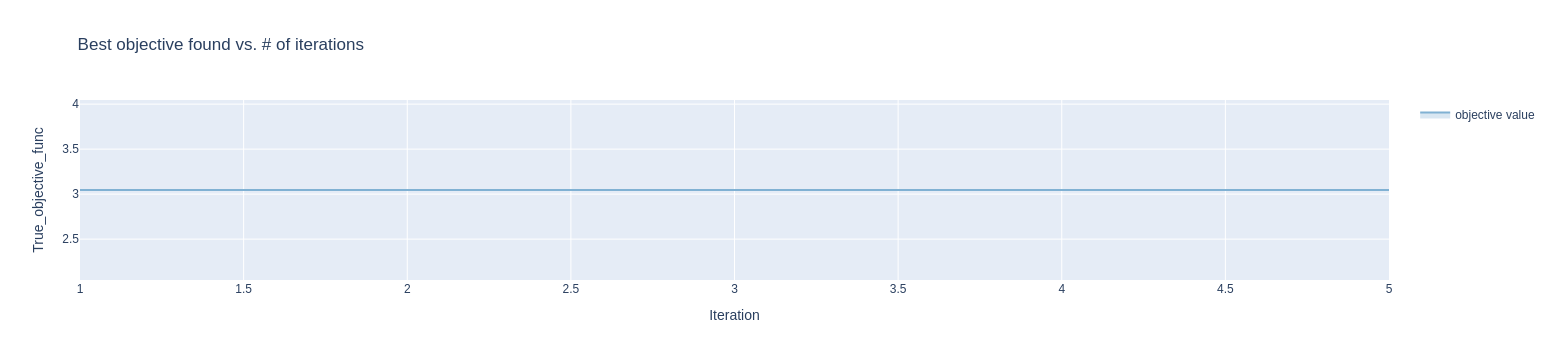

In [32]:
render(ax_client.get_optimization_trace())

In [15]:
import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(
render(ax_client.get_contour_plot(param_x="aLund", param_y="bLund",))
# )


# fig.show()
# fig.write_image("images/Lund_a_b_countour.pdf")

[INFO 05-28 19:05:10] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.
[ERROR 05-28 19:05:10] ax.plot.helper: Have observations of arms with different features but same name. Arbitrary one will be plotted.
[INFO 05-28 19:05:10] ax.service.ax_client: Model RandomModelBridge(model=SobolGenerator) does not implement `predict`, so it cannot be used to generate a response surface plot.


UnsupportedPlotError: Could not obtain contour plot of "true_objective_func" for parameters "aLund" and "bLund", as a model with predictive ability, such as a Gaussian Process, has not yet been trained in the course of this optimization.

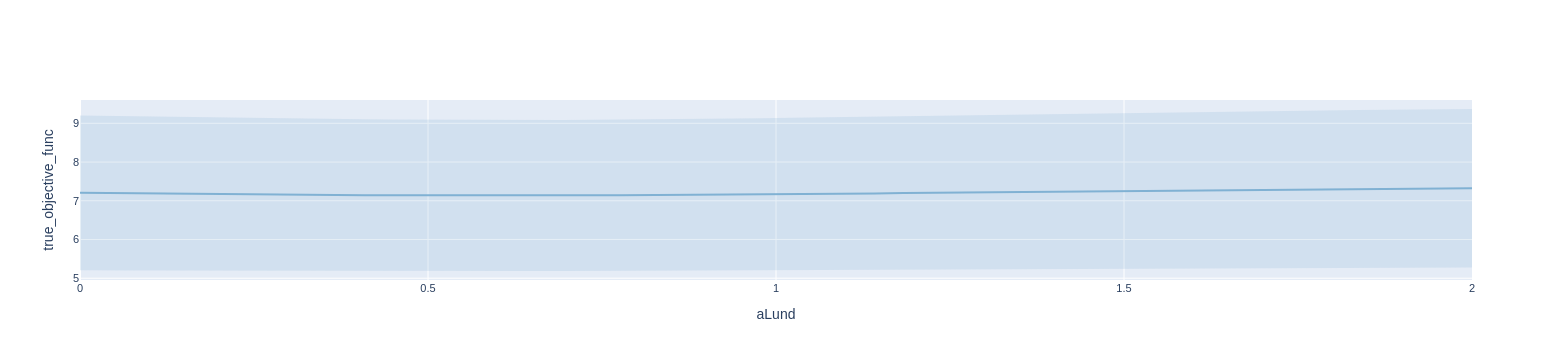

In [14]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "aLund", "true_objective_func"))

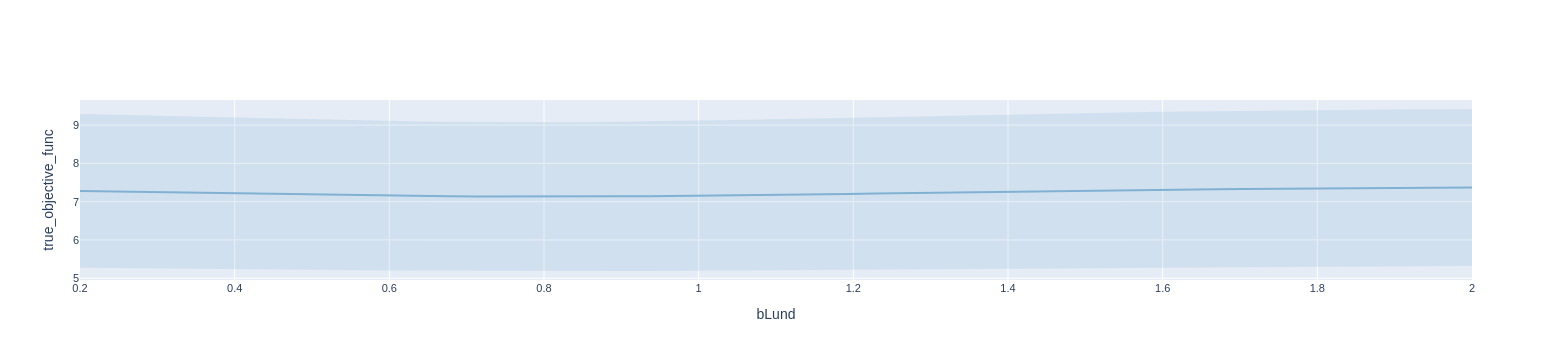

In [15]:
render(plot_slice(model, "bLund", "true_objective_func"))

----

## Validate the results

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [33]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactB"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["aExtraSQuark"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["aExtraDiquark"]))
        f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

In [34]:
run_valid_card(best_parameters)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |

Rivet 3.1.9 running on machine 0e0cae350635 (x86_64) at 2024-05-28 20:13:36
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:02 elapsed)
Event 300 (0:00:03 elapsed)
Event 400 (0:00:04 elapsed)
Event 500 (0:00:05 elapsed)
Event 600 (0:00:06 elapsed)
Event 700 (0:00:06 elapsed)
Event 800 (0:00:07 elapsed)
Event 900 (0:00:09 elapsed)
Event 1000 (0:00:09 elapsed)
Event 1100 (0:00:11 elapsed)
Event 1200 (0:00:12 elapsed)
Event 1300 (0:00:13 elapsed)
Event 1400 (0:00:14 elapsed)
Event 1500 (0:00:14 elapsed)
Event 1600 (0:00:14 elapsed)
Event 1700 (0:00:14 elapsed)
Event 1800 (0:00:15 elapsed)
Event 1900 (0:00:15 elapsed)
Event 2000 (0:00:15 elapsed)
Event 2100 (0:00:15 elapsed)
Event 2200 (0:00:15 elapsed)
Event 2300 (0:00:16 elapsed)
Event 2400 (0:00:16 elapsed)
Event 2500 (0:00:16 elapsed)
Event 2600 (0:00:16 elapsed)
Event 2700 (0:00:17 elapsed)
Event 2800 (0:00:17 elapsed)
Event 2900 (0:00:17 elapsed)
Event 3000 (0





Rivet.AnalysisHandler: INFO  Using named weights


In [35]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy

def get_valid_data():
    # tracemalloc.start()
    yoda2numpy = Yoda2Numpy()
    files = list(glob('ALEPH_YODAS_BayesOpt/*.yoda'))
    M = len(files)
    # M = 
    generated_indices = []
    for file in files[:M]:
        index = file.split('_')[-1].split('.')[0]
        generated_indices.append(int(index))    
    generated_indices.sort()
    print(generated_indices)
    # # --- SIM
    print(f'looping over {M:d} sim yoda files...\n')
    # dfsims = []
    dfsims_valid = {}
    for ii in tqdm(generated_indices):    
        # index here should match the index of the file
        # dfsims.append( yoda2numpy.todf( yoda2numpy('sim', index=ii) ) )
        dfsims_valid[ii]= yoda2numpy.todf( yoda2numpy('val', index=ii) ) 

    # # --- NEW
    # print(f'looping over {M:d} new yoda files...\n')
    # # dfnews = []
    # # for ii in tqdm(range(M)):
    # #     dfnews.append( yoda2numpy.todf( yoda2numpy('new', index=ii) ) )

    print()
    # key = '/ALEPH_1996_S3486095/d01-x01-y01'
    # dfsim = dfsims[0][key]
    
    dfdata = yoda2numpy.todf( yoda2numpy('dat') )
    
    return dfdata, dfsims_valid, generated_indices

In [36]:
dfdata, dfsims_valid, generated_indices = get_valid_data()

[0]
looping over 1 sim yoda files...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


In [37]:
print(generated_indices)
# print(dfsims)
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM-VALID DATAFRAME')
print(dfsims_valid[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

[0]
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM-VALID DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.560000  0.007707  0.039850  0.030000     17340.0
1  0.005  0.010  23.747999  0.015832  0.178023  0.276630     35622.0
2  0.010  0.015  20.660000  0.013773  0.256861  0.647315     30990.0
3  0.015  0.020  17.116667  0.011411  0.297845  1.043653     25675.0
4  0.020  0.025  13.822000  0.009215  0.309706  1.393566     20733.0


In [38]:
data_keys, mc_keys = get_hist_names(dfdata)
filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims_valid, data_keys, mc_keys)

 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

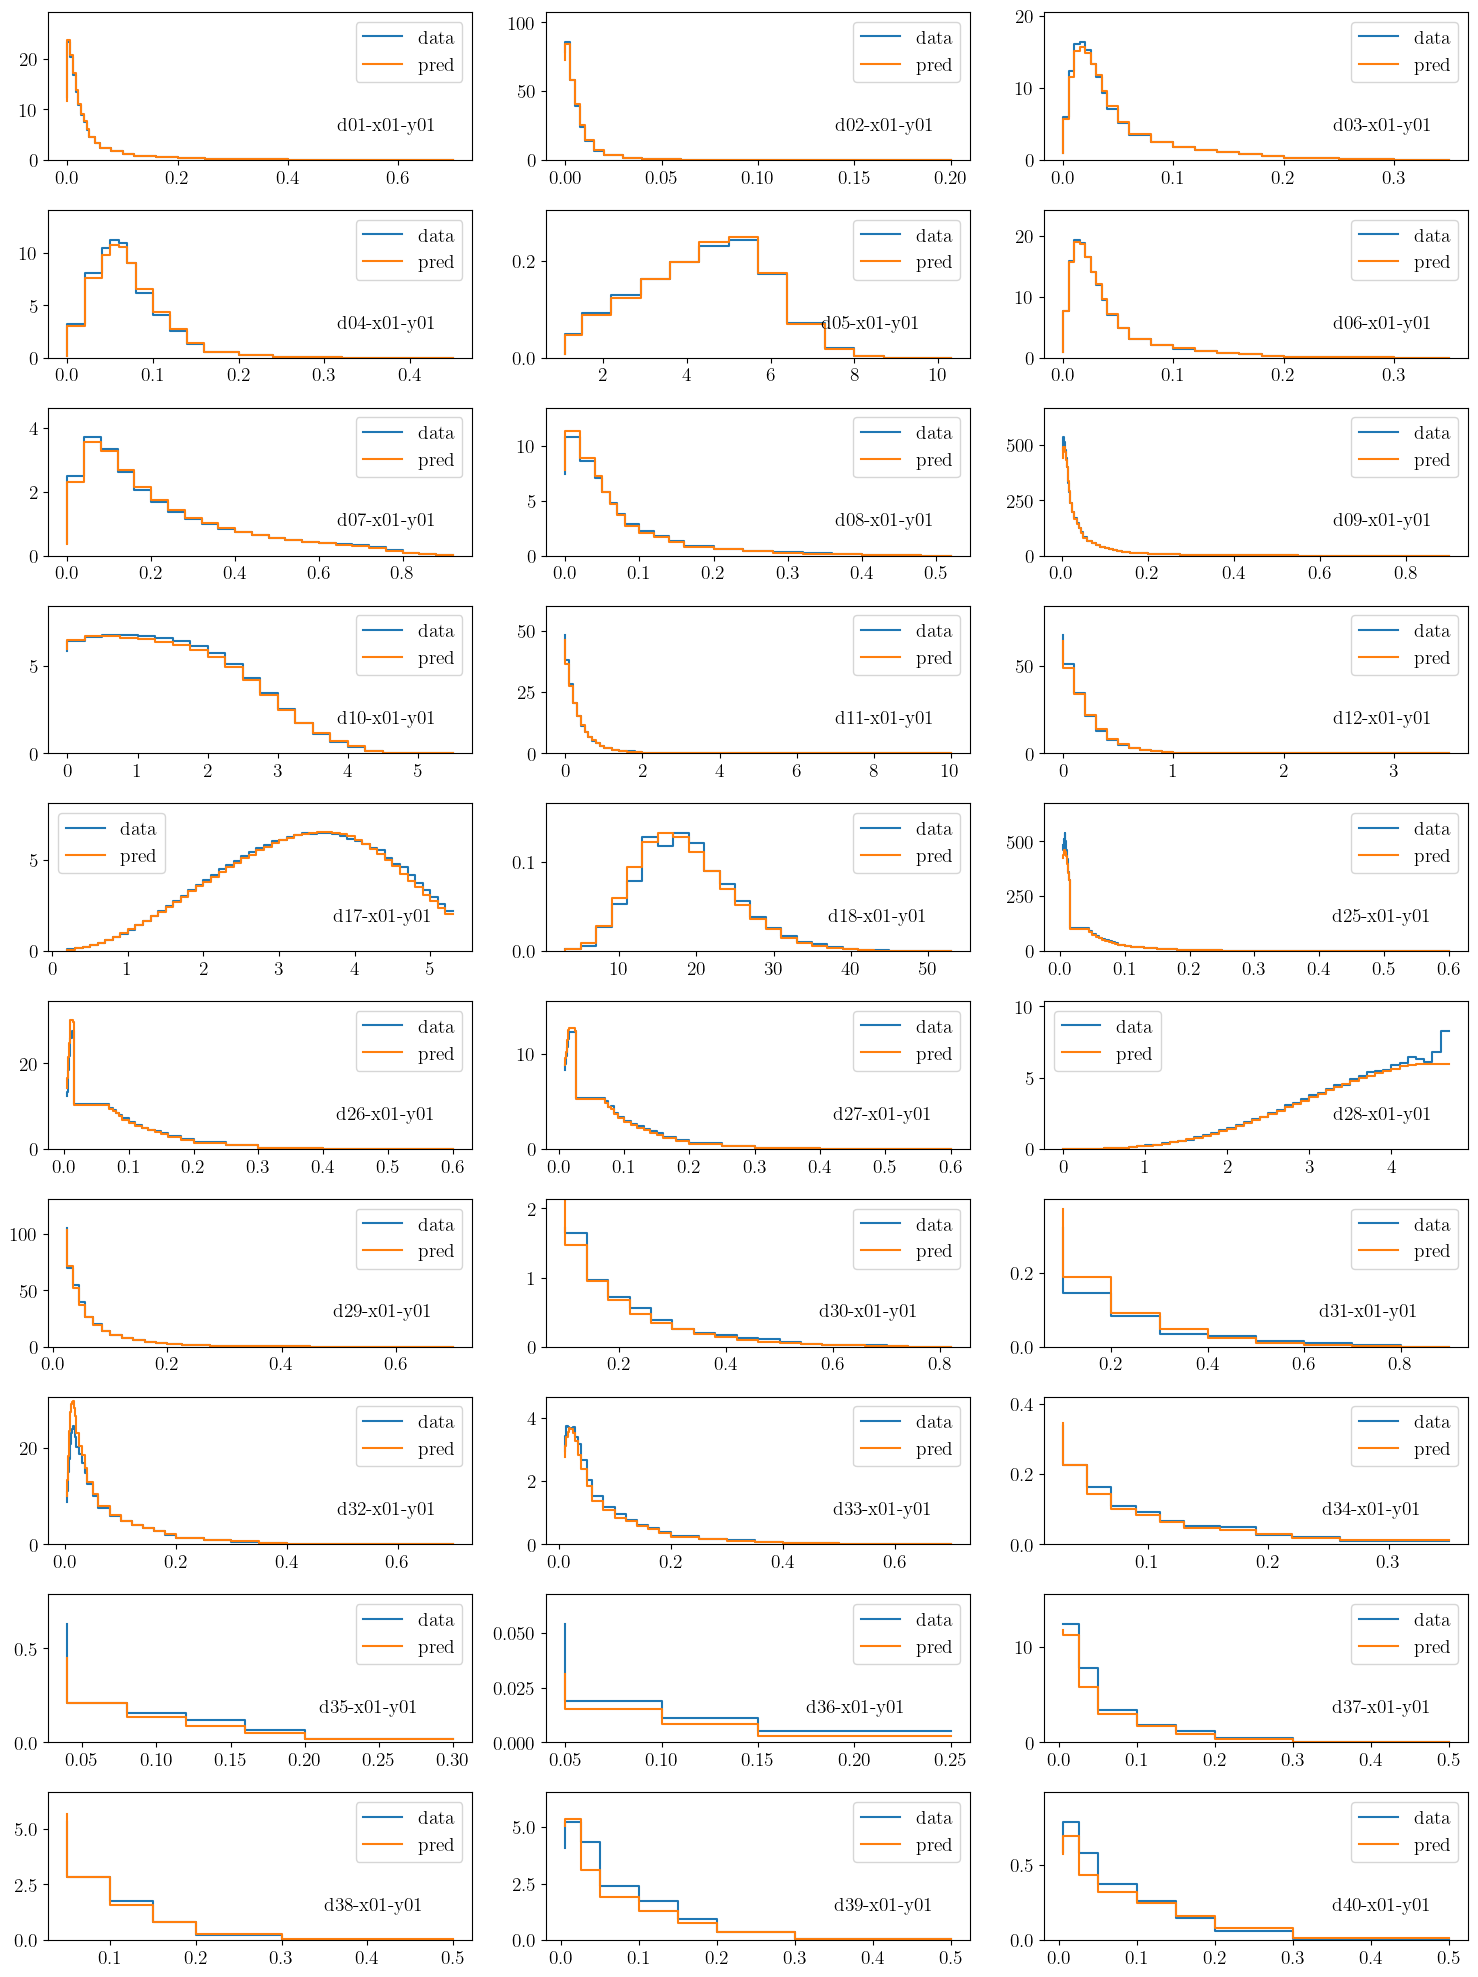

In [40]:
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import * 

hists = make_hists(dfdata, dfsims_valid[0], filtered_data_keys, filtered_mc_keys)

plot_dist(filtered_data_keys, hists, filename='images/Ax_BayesianOpt_Valid_Best_fit_hists_all_params_3_iter.pdf')